In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
def safelog2(x):
    if x == 0:
        return(0)
    else:
        return(np.log2(x))

In [8]:
data_set = np.genfromtxt("hw05_data_set.csv", delimiter = ",")

# get X and y values
X = data_set[1:, 0]
y = data_set[1:, 1]

# get number of classes, number of samples, and number of features
K = np.max(y)
N = X.shape[0]
D = 2

# get train and test splits
train_indices = np.concatenate((np.arange(0, 25), np.arange(50, 75), np.arange(100, 125)))
test_indices = np.setdiff1d(range(N), train_indices)

x_ = data_set[1:,0]
y_ = data_set[1:,1].astype(int)

K = np.max(y_)
N = data_set.shape[0]


X_train = x_[:150]
Y_train = y_[:150]


x_test = x_[150:]
y_test = y_[150:]


# get numbers of train and test samples
N_train = len(Y_train)
N_test = len(y_test)

In [9]:
node_indices = {}
is_terminal = {}
need_split = {}

node_features = {}
node_splits = {}
node_frequencies = {}

# put all training instances into the root node
node_indices[1] = np.array(range(N_train))
is_terminal[1] = False
need_split[1] = True

In [10]:
def getError(left_indices, right_indices, y_train):
    if left_indices.size == 0: return 0
    elif right_indices.size == 0: return 0
    errorRate = 0
    if len(left_indices)>0:
        errorRate += np.sum((y_train[left_indices] - np.mean(y_train[left_indices])) ** 2)
    if len(right_indices)>0:
        return errorRate + np.sum((y_train[right_indices] - np.mean(y_train[right_indices])) ** 2)
    return errorRate

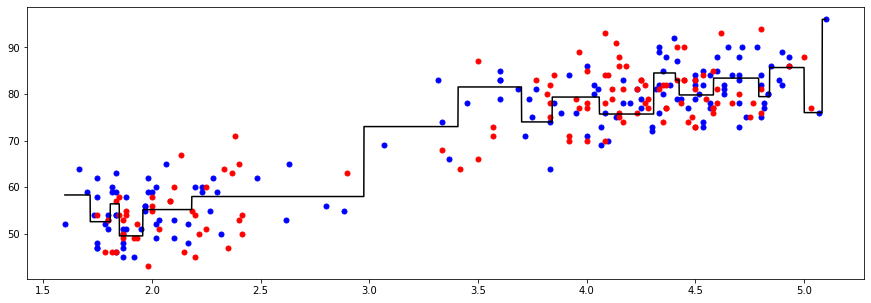

In [11]:
def tree(x_train, y_train, P):
    #ds
    node_indices = {}
    is_terminal = {}
    need_split = {}
    node_means = {}
    node_splits = {}

    node_indices[1] = np.array(range(len(x_train)))
    is_terminal[1] = False
    need_split[1] = True
    
    while 1:
        
        # find nodes that need splitting
        split_nodes = [key for key,  value in need_split.items() if value == True]
        if len(split_nodes) == 0:
            break
        # find best split positions for all nodes
        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            node_mean = np.mean(y_train[data_indices])
            if len(np.unique(y_train[data_indices])) == 1:
                    is_terminal[split_node] = True    
            
            if x_train[data_indices].size <= P:
                is_terminal[split_node] = True
                node_means[split_node] = node_mean
                
            else:
                is_terminal[split_node] = False
                s_vals = np.sort(np.unique(x_train[data_indices]))
                split_positions = (s_vals[1:len(s_vals)] + s_vals[0: (len(s_vals) - 1 )]) / 2
                split_scores = np.repeat(0.0, len(split_positions))
                if len(np.unique(y_train[data_indices])) == 1:
                    is_terminal[split_node] = True
                    
                for s in range(len(split_positions)):
                    left_indices = data_indices[x_train[data_indices] < split_positions[s]]
                    right_indices = data_indices[x_train[data_indices] >= split_positions[s]]
                    tot = 0
                    tot = getError(left_indices, right_indices, y_train)
                    split_scores[s] = tot / (len(left_indices) + len(right_indices))
                    
                #if len 1 is when we take unique values
                if len(s_vals) == 1 :
                    is_terminal[split_node] = True
                    node_means[split_node] = node_mean
                    continue
                best_split = split_positions[np.argmin(split_scores)]
                node_splits[split_node] = best_split
                
                # create left node using the selected split
                left_indices = data_indices[(x_train[data_indices] < best_split)]
                node_indices[2 * split_node] =left_indices
                is_terminal[2 * split_node]  = False
                need_split[2 * split_node] = True

                # create right node using the selected split
                right_indices = data_indices[(x_train[data_indices] >= best_split)]
                node_indices[(2 * split_node) + 1] = right_indices
                is_terminal[(2 * split_node) + 1] = False
                need_split[(2 * split_node) + 1]  = True
                if len(np.unique(y_train[data_indices])) == 1:
                    is_terminal[split_node] = True
    return node_splits, node_means, is_terminal

def predict(x, node_splits, node_means, is_terminal):
    index = 1
    while 1:
        if is_terminal[index] == True:
            return node_means[index]
        if x > node_splits[index]:
            index = index * 2 + 1
        else:
            index = index * 2

P = 15


node_splits, node_means, is_terminal = tree(X_train, Y_train, P)
pred = [predict(x, node_splits, node_means, is_terminal) for x in x_test]
pred = np.array(pred)

data_interval = np.arange(min(X_train), max(X_train), 0.001)
fig = plt.figure(figsize=(15, 5))

plt.plot(X_train, Y_train, "b.",  markersize=10)
plt.plot(x_test, y_test, "r.",  markersize=10)

int_plot = list()

for i in range(len(data_interval)):
    int_plot.append(predict(data_interval[i], node_splits, node_means, is_terminal))
    
plt.plot(data_interval, int_plot, color="black")
plt.show()

In [14]:
def rmseForP(P):
    node_splits, node_means, is_terminal = tree(X_train, Y_train, P)
    sums = 0
    for i in range(len(X_train)):
        pred = predict(X_train[i],node_splits, node_means, is_terminal)
        errorsq = (Y_train[i] - pred) ** 2
        sums = sums + errorsq
    rmse = math.sqrt(sums / len(Y_train) )
    return rmse

In [15]:
def rmseForPts(P):
    rmse = 0
    node_splits, node_means, is_terminal = tree(x_test, y_test, P)
    sums = 0
    for i in range(len(x_test)):
        pred = predict(x_test[i], node_splits, node_means, is_terminal)
        errorsq = (y_test[i] - pred) ** 2
        sums = sums + errorsq
    rmse = math.sqrt(sums / len(y_test) )
    return rmse

In [16]:
PList = list(np.array([i*5 for i in range(11)]) + 5)

In [17]:
ad2 = list()
for i in PList:
    ad2.append(rmseForPts(i))

In [18]:
ad = list()
for i in PList:
    ad.append(rmseForP(i))

In [19]:
ad2 = list(12.5 - np.array(ad2) * 2 + np.array(ad))

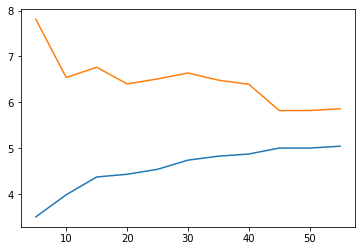

In [20]:
plt.plot(PList, ad)
plt.plot(PList, ad2)